In [1]:
from mlwpy import *
%matplotlib inline

iris = datasets.load_iris()
diabetes = datasets.load_diabetes()
digits = datasets.load_digits()

## Models, Parameters, Hyperparameters

In [2]:
def add_three(x):
    return 3 + x
def add(x, y):
    return x + y

add(10,3) == add_three(10)

True

In [3]:
def make_adder(k):
    def add_k(x):
        return x + k
    return add_k

In [4]:
three_adder = make_adder(3)

three_adder(10 == add_three(10))

3

In [5]:
knn = neighbors.KNeighborsClassifier()
print(" ".join(knn.get_params().keys()))

algorithm leaf_size metric metric_params n_jobs n_neighbors p weights


In [6]:
param_grid = {"n_neighbors" : [1,3,5,10,20]}

knn = neighbors.KNeighborsClassifier()

# NOTE: this is with accuracy
grid_model = skms.GridSearchCV(knn, return_train_score=True,
                               param_grid=param_grid, cv=10)

grid_model.fit(digits.data, digits.target)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 10, 20]},
             return_train_score=True)

In [7]:
# many columns in .cv_results_
# all params are also available in 'params' column as dict
param_cols = ['param_n_neighbors']
score_cols = ['mean_train_score', 'std_train_score',
              'mean_test_score', 'std_test_score']

# look at first five params with head()
df = pd.DataFrame(grid_model.cv_results_).head()

display(df[param_cols + score_cols])

,param_n_neighbors,mean_train_score,std_train_score,mean_test_score,std_test_score
0,1,1.0000,0.0000,0.9750,0.0171
1,3,0.9933,0.0008,0.9766,0.0155
2,5,0.9905,0.0006,0.9711,0.0172
3,10,0.9858,0.0013,0.9622,0.0205
4,20,0.9807,0.0017,0.9588,0.0224


In [8]:
# subselect columns of interest:
# param_* is a bit verbose

grid_df = pd.DataFrame(grid_model.cv_results_, 
                       columns=['param_n_neighbors',
                                'mean_train_score',
                                'mean_test_score'])

grid_df.set_index('param_n_neighbors', inplace=True)
display(grid_df)

,mean_train_score,mean_test_score
param_n_neighbors,,
1,1.0000,0.9750
3,0.9933,0.9766
5,0.9905,0.9711
10,0.9858,0.9622
20,0.9807,0.9588


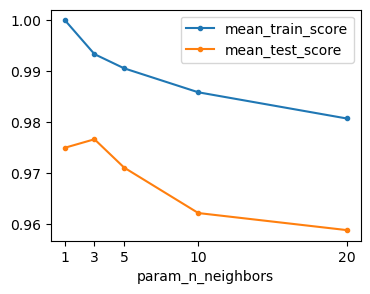

In [9]:
ax = grid_df.plot.line(marker='.')
ax.set_xticks(grid_df.index);

In [10]:
def best_model_hyper_params(make_a_model, some_hyper_params,data):
    results = {}
    
    for hyper_params in it.combinations(some_hyper_params):
        for train,test in make_cv_split(data):
            model = make_a_model('hyper_params').fit(train)
            key = tuple(hyper_params)
            if key not in results:
                results[key] = []
            results[key].append(score(test, model.predict(test)))
            
    best_hp = max(results, key=results.get)
    best_model = make_a_model('best_hp').fit(data)
    return best_model

def do_it():
    model = pick_a_model
    
    some_hyper_params = [values_for_hyper_param_1,
                        values_for_hyper_param_2,
                        values_for_hyper_param_3]
    
    best_model_hyper_params(model_type,
                            some_hyper_params,
                            data)

In [11]:
param_grid = {"n_neighbors" : np.arange(1,11),
              "weights"     : ['uniform', 'distance'],
              "p"           : [1,2,4,8,16]}

knn = neighbors.KNeighborsClassifier()
grid_model = skms.GridSearchCV(knn, param_grid = param_grid, cv=10)

In [12]:
# %timeit -r1 grid_model.fit(digits.data, digits.target)
%timeit -r1 grid_model.fit(iris.data, iris.target)

2.49 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [13]:
param_df = pd.DataFrame.from_records(grid_model.cv_results_['params'])
param_df['mean_test_score'] = grid_model.cv_results_['mean_test_score']
param_df.sort_values(by=['mean_test_score']).tail()

,n_neighbors,p,weights,mean_test_score
75,8,4,distance,0.9800
74,8,4,uniform,0.9800
98,10,16,uniform,0.9800
88,9,16,uniform,0.9800
99,10,16,distance,0.9800


In [14]:
print("Best Estimator:", grid_model.best_estimator_,
      "Best Score:", grid_model.best_score_,
      "Best Params:", grid_model.best_params_,sep="\n")

Best Estimator:
KNeighborsClassifier(n_neighbors=8, p=4)
Best Score:
0.9800000000000001
Best Params:
{'n_neighbors': 8, 'p': 4, 'weights': 'uniform'}


In [15]:
import scipy.stats as ss
knn = neighbors.KNeighborsClassifier()
param_dists = {"n_neighbors" : ss.randint(1,11),
               "weights"     : ['uniform','distance'],
               "p"           : ss.geom(p=.5)}

mod = skms.RandomizedSearchCV(knn,
                              param_distributions = param_dists,
                              cv=10,
                              n_iter=20)


# fitting 20 models
%timeit -r1 mod.fit(iris.data, iris.target)
print(mod.best_score_)

482 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
0.9800000000000001


In [16]:
mod.scorer_

<function sklearn.metrics._scorer._passthrough_scorer(estimator, *args, **kwargs)>

In [17]:
param_grid = {"n_neighbors" : np.arange(1,11),
              "weights"     : ['uniform', 'distance'],
              "p"           : [1,2,4,8,16]}

knn = neighbors.KNeighborsClassifier()
grid_knn = skms.GridSearchCV(knn, param_grid = param_grid, cv=3)

In [18]:
outer_scores = skms.cross_val_score(grid_knn, iris.data, iris.target,cv=5)

print(outer_scores)

[0.9667 1.     0.9333 0.9667 1.    ]


In [19]:
def nested_cv_pseudo_code(all_data):
    results = []
    for outer_train, test in make_cv_split(all_data):
        for hyper_params in hyper_parameter_possibilities:
            for train, valid in make_cv_split(outer_train):
                inner_score = evaluate(model.fit(train).predict(valid))
        best_mod = xxx # choose model with best inner_score
        preds = best_model.fit(outer_train).predict(test)
        results.append(evaluate(preds))

In [20]:
param_grid = {"n_neighbors" : np.arange(1,11),
              "weights"     : ['uniform', 'distance'],
              "p"           : [1,2,4,8,16]}

knn = neighbors.KNeighborsClassifier()
grid_knn = skms.GridSearchCV(knn, param_grid = param_grid, cv=2)

outer_scores = skms.cross_val_score(grid_knn, iris.data, iris.target,cv=5)
print(outer_scores)

[0.9667 0.9667 0.9333 0.9667 1.    ]


In [21]:
grid_knn.fit(iris.data, iris.target)
preferred_params = grid_knn.best_estimator_.get_params()
final_knn = neighbors.KNeighborsClassifier(**preferred_params)
final_knn.fit(iris.data, iris.target)

KNeighborsClassifier(n_neighbors=7, p=4, weights='distance')

## Pipelines

In [22]:
scaler = skpre.StandardScaler()
logreg = linear_model.LogisticRegression()

pipe = pipeline.make_pipeline(scaler, logreg)
print(skms.cross_val_score(pipe, iris.data, iris.target, cv=10))

[1.     0.9333 1.     1.     0.9333 0.9333 0.8    1.     1.     1.    ]


In [23]:
def extract_name(obj):
    return str(logreg.__class__).split('.')[-1][:-2].lower()


print(logreg.__class__)
print(extract_name(logreg))

<class 'sklearn.linear_model._logistic.LogisticRegression'>
logisticregression


In [24]:
pipe.named_steps.keys()

dict_keys(['standardscaler', 'logisticregression'])

In [25]:
pipe = pipeline.Pipeline(steps=[('scaler', scaler),
                                ('knn', knn)])

cv_scores = skms.cross_val_score(pipe, iris.data, iris.target, 
                                 cv=10, n_jobs=-1)

print(pipe.named_steps.keys())
print(cv_scores)

dict_keys(['scaler', 'knn'])
[1.     0.9333 1.     0.9333 0.8667 0.9333 0.8667 1.     1.     1.    ]


In [26]:
from sklearn.base import TransformerMixin

class Median_Big_Small(TransformerMixin):
    def __init__(self):
        pass
    def fit(self, ftrs, tgt=None):
        self.medians = np.median(ftrs)
        return self
    def transform(self, ftrs, tgt=None):
        return ftrs > self.medians

In [27]:
scaler = skpre.StandardScaler()
quad_inters = skpre.PolynomialFeatures(degree=2, interaction_only=True,
                                       include_bias=False)

median_big_small = Median_Big_Small()
knn = neighbors.KNeighborsClassifier()

pipe = pipeline.Pipeline(steps=[('scaler', scaler),
                                ('inter', quad_inters),
                                ('mbs', median_big_small),
                                ('knn', knn)])

cv_scores = skms.cross_val_score(pipe, iris.data, iris.target, cv=10)

print(cv_scores)

[0.6    0.6667 0.8    0.7333 0.8    0.6667 0.6667 0.6667 0.8667 0.8   ]


In [28]:
# create pipeline components and pipeline
scaler = skpre.StandardScaler()
poly = skpre.PolynomialFeatures()
lasso = linear_model.Lasso(selection='random', tol=0.1)
pipe = pipeline.make_pipeline(scaler, poly, lasso)

In [29]:
# specified hyperparameters to compare
param_grid = {"polynomialfeatures__degree" : np.arange(2,6),
              "lasso__alpha"               : np.logspace(1,6,6,base=2)}

from pprint import pprint as pp
pp(param_grid)

{'lasso__alpha': array([ 2.,  4.,  8., 16., 32., 64.]),
 'polynomialfeatures__degree': array([2, 3, 4, 5])}


In [30]:
# iid to silence warning
mod = skms.GridSearchCV(pipe, param_grid, n_jobs=-1)
mod.fit(diabetes.data, diabetes.target)



GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('lasso',
                                        Lasso(selection='random', tol=0.1))]),
             n_jobs=-1,
             param_grid={'lasso__alpha': array([ 2.,  4.,  8., 16., 32., 64.]),
                         'polynomialfeatures__degree': array([2, 3, 4, 5])})

In [31]:
for name, step in mod.best_estimator_.named_steps.items():
    print("Step:", name)
    print(textwrap.indent(textwrap.fill(str(step), 50), " " * 6))

Step: standardscaler
      StandardScaler()
Step: polynomialfeatures
      PolynomialFeatures()
Step: lasso
      Lasso(alpha=4.0, selection='random', tol=0.1)


In [32]:
pp(mod.best_params_)

{'lasso__alpha': 4.0, 'polynomialfeatures__degree': 2}


/usr/local/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/usr/local/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no long

In [3]:
#cg: this code forces the kernel to restart - why?

import xgboost

xgbooster = xgboost.XGBClassifier(objective="multi:softmax")
scores = skms.cross_val_score(xgbooster, iris.data, iris.target, cv=10)
print(scores)

[12:47:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:47:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:47:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:47:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol